In [1]:
import os
import numpy as np
import galsim
import sys
import descwl
import argparse

import copy
%matplotlib inline
import matplotlib.pyplot as plt

#importing scarlet to make RGB images
import scarlet.display

sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk

In [2]:
#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'OneDegSq.fits')

In [3]:
class Simulation_params(object):
    """Parametrs to create blends.
    Args:
        catalog_name: Name of input catalog from which to draw objects.
        max_number: Maximum number of objects per blend.
        batch_size: Number of blends to si,utae per batch.
        stamp_size: Size of postage stamp in arcseconds.
        survey_name: Name of survey to select observing conditions. 
        seed: random seed.
        add_noise: If True, adds noise to output blended images.
        bands: Filters in which to simulate images.
    """
    def __init__(self, catalog_name, max_number=2,
                 batch_size=8, stamp_size=24, survey_name="LSST",
                 seed=0, add_noise=True,
                 bands = ('u', 'g', 'r', 'i', 'z', 'y')):
        self.catalog_name = catalog_name
        self.max_number = max_number
        self.batch_size = batch_size
        self.stamp_size = stamp_size
        self.survey_name = survey_name
        self.add_noise = add_noise
        self.seed = seed
        self.bands = bands

def plot_blends(param, blend_images, blend_list, limits=None):
    """Plots blend images as RGB(g,r,i) image, sum in all bands, and RGB with centers of objects marked"""
    for i in range(param.batch_size):    
        num = len(blend_list[i])
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        norm = scarlet.display.Asinh(img=images, Q=20)
        blend_img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
        plt.figure(figsize=(12,5))
        plt.subplot(131)
        plt.imshow(blend_img_rgb)
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.title("gri bands")
        plt.axis('off')

        plt.subplot(132)
        plt.imshow(np.sum(blend_images[i, :, :, :], axis=2))
        plt.title("Sum")
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(blend_img_rgb)
        plt.title("%i objects with centers"%num)
        for entry in blend_list[i]:
            plt.plot(entry['ra']/0.2 + 59, entry['dec']/0.2 + 59,'rx')
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')
        plt.show()

def plot_with_isolated(param, blend_images, isolated_images,
                       blend_list, limits=None):
    """Plots blend images and isolated images of all objects in the blend as RGB(g,r,i) images"""
    for i in range(param.batch_size):    
        num = param.max_number
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        norm = scarlet.display.Asinh(img=images, Q=20)
        blend_img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
        plt.imshow(blend_img_rgb)
        plt.title("%i objects"%len(blend_list[i]))
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')
        plt.show()
        plt.figure(figsize=(15,5))
        for j in range(len(blend_list[i])):
            plt.subplot(1, num, j +1 )
            images = np.transpose(isolated_images[i, j, :, :, 1:4], axes=(2,0,1))
            blend_img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
            plt.imshow(blend_img_rgb)
            #plt.plot(blend_list[i]['ra'][j]/0.2 + 59, blend_list[i]['dec'][j]/0.2 + 59,'rx')
            if limits:
                plt.xlim(limits)
                plt.ylim(limits)
            plt.axis('off')
        plt.show()

In [4]:
def new_center_shift(Args, number_of_objects):
    """Set shift in galaxy centers from a normal distribution with mean 0 and std 1 arcseconds"""
    mean, sigma = 0, 1 #arcseconds
    dx = np.random.normal(mean, sigma, number_of_objects)
    dy = np.random.normal(mean, sigma, number_of_objects)
    return dx, dy
    
def new_sampling_function(Args, catalog):
    """ Samples galaxies with i<24, r-i>1. Number of objects ber blend is selected from a poisson
    distribution of mean 3. The number of objects is restricted to max_number. The centers of the objects 
    are set in new function new_center_shift()
    Note:Sampling function must clip the number of objects to Args.max_number!
    """
    # Set number of objets per blend
    number_of_objects = np.random.poisson(3)
    number_of_objects = np.minimum(number_of_objects, Args.max_number)
    
    # Make galaxy sample
    q, = np.where((catalog['i_ab'] <= 24) & (np.abs(catalog['i_ab'] - catalog['r_ab']) >1))
    blend_catalog = catalog[np.random.choice(q, size=number_of_objects)]
    
    # galaxy centers are sent as random shift from 0,0
    blend_catalog['ra'], blend_catalog['dec'] = 0., 0.
    dx, dy = new_center_shift(Args, number_of_objects)
    blend_catalog['ra'] += dx
    blend_catalog['dec'] += dy
    return blend_catalog

In [5]:
# Load parameters
param = Simulation_params(catalog_name, max_number=6, batch_size=5)
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catlog(catalog_name)

#Generate catlogs of blended objects 
blend_genrator = btk.create_blend_generator.generate(param, catalog, new_sampling_function)

#Generates observing conditions for the selected survey_name and all input bands
observing_genrator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_genrator, observing_genrator)    

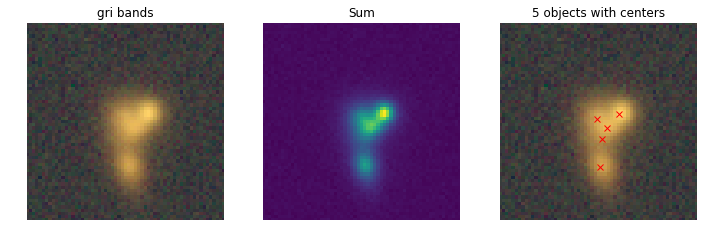

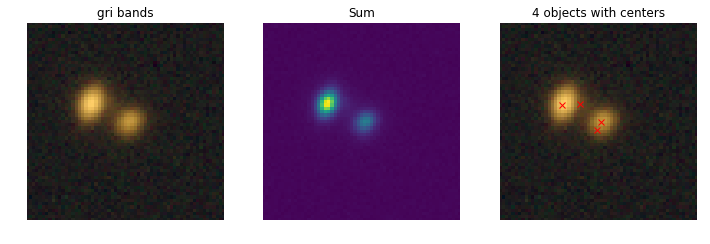

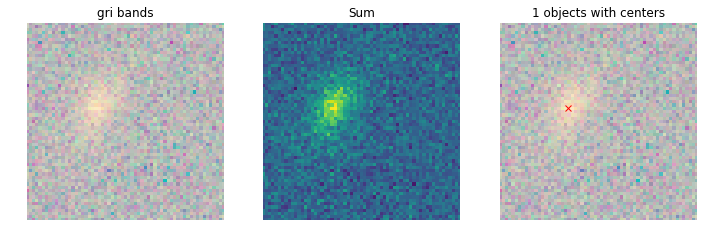

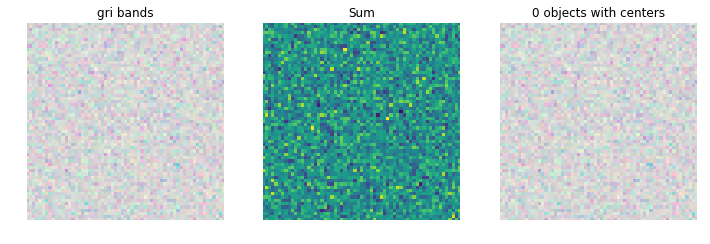

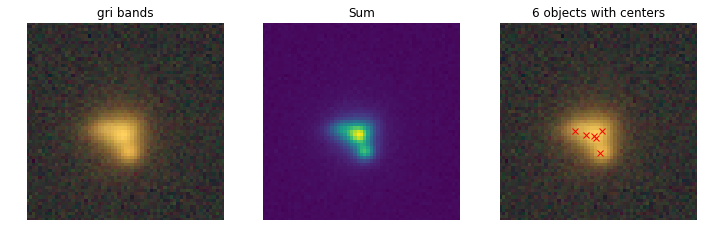

In [6]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
blend_images, isolated_images, blend_list = blend_results

# Plot blended images
plot_blends(param, blend_images, blend_list, limits=(30,90))

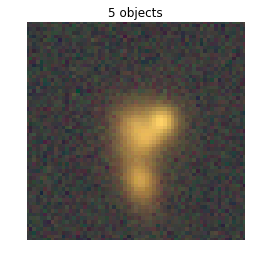

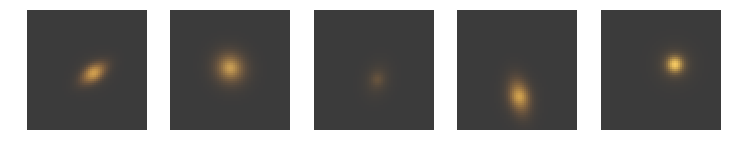

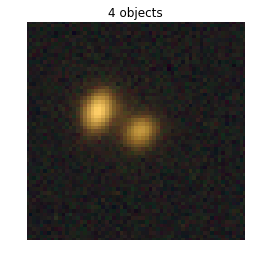

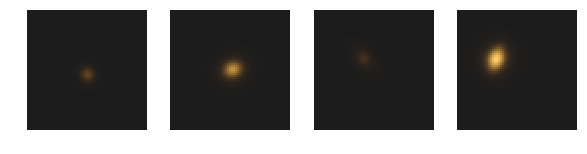

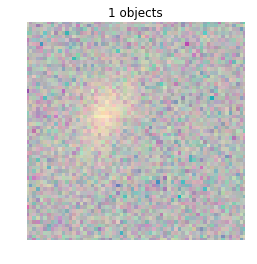

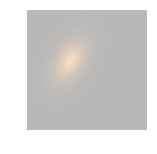

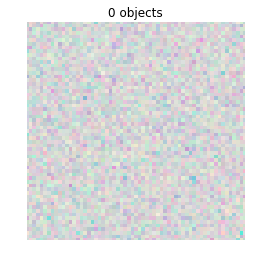

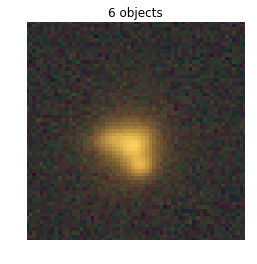

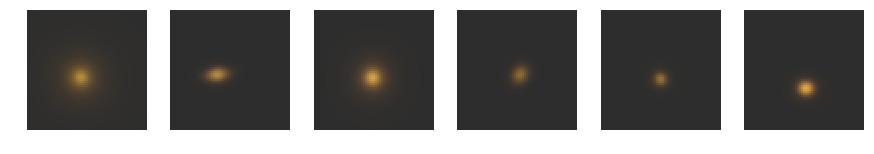

In [7]:
# Plot blended images and the individual objects
plot_with_isolated(param, blend_images, isolated_images,blend_list, limits=(30,90))